In [1]:
import os
import numpy as np
from tensorflow import keras
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

plt.style.use('ggplot')

In [2]:
model_name = r"model_test.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"

model_path = os.path.join(model_path, model_name)

class MonteCarloDropout(keras.layers.Dropout):
    """Keeps dropout on in testing mode for uncertainty predictions"""
    def call(self, inputs):
        return super().call(inputs, training=True)

model = keras.models.load_model(model_path, custom_objects={"f1_score": f1_score, "MonteCarloDropout": MonteCarloDropout})

with open(os.path.join(load_path, "processed_data.pickle"), "rb") as handle:
    combined_data = pickle.load(handle)

y_test = combined_data['y_test']
y_train = combined_data['y_train']

event_X_test = combined_data['event_X_test']
object_X_test = combined_data['object_X_test']

In [20]:
n_models = 500

def generate_sample():
    n = np.random.randint(0, event_X_test.shape[0])
    return [event_X_test.iloc[n:n+1].values, object_X_test[n:n+1]]


def predict_dist(X, model, n_models):
    preds = [model(X, training=False) for _ in range(n_models)]
    return np.hstack(preds)


def plot_dist(sample, model, n_models):
    y_pred_dist = predict_dist(sample, model, n_models)
    y_pred = y_pred_dist.mean(axis=1)

    plt.figure(figsize=(10, 8))
    sns.kdeplot(y_pred_dist[0], shade=True)
    plt.axvline(y_pred[0])
    plt.show()

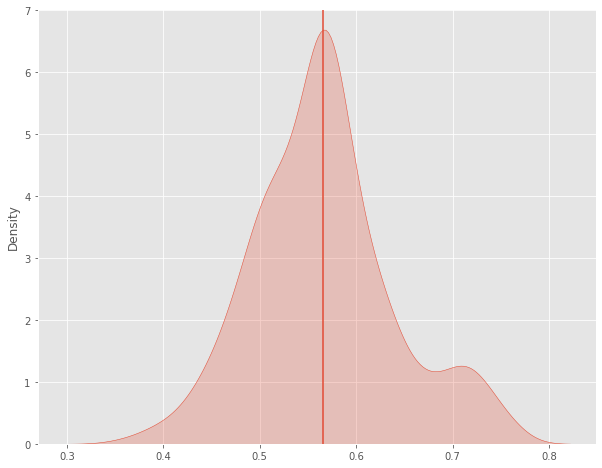

In [21]:
sample = generate_sample()
plot_dist(sample, model, n_models)

In [4]:
# add tqdm because this loop takes forever
n_samples = 1000
n_models = 10
errors = []

def predict_sample(X, model, n_models):
    preds = [model(X, training=False) for _ in range(n_models)]
    mean = sum(preds) / len(preds)
    mean = float(mean[0][0])
    std = np.std(preds)
    return (mean, std)

for _ in range(n_samples):
    sample = generate_sample()
    error = predict_sample(sample, model, n_models)
    errors.append(error)

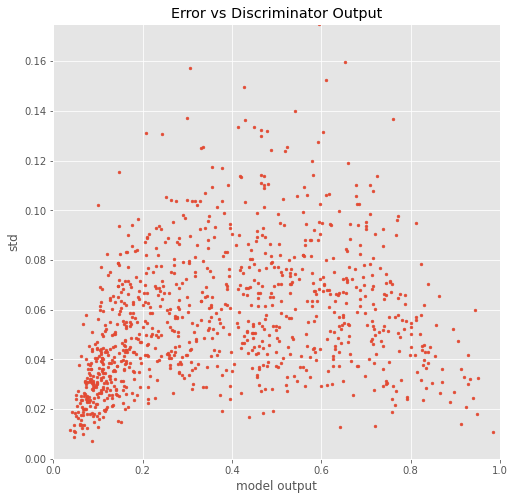

In [56]:
plt.figure(figsize=(8, 8))
plt.xlabel('model output')
plt.ylabel('std')
plt.title('Error vs Discriminator Output')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.175])
plt.scatter(*zip(*errors), s=8)
# colour the points by whether the prediction was true or not

In [ ]:
# maybe calculate the correlation between whether its correct and the std
# similarly, could plot the prediction error (y_true - y_pred) vs std for a large number of samples
# maybe also the average uncertainty over the whole test set
# also compare mean dropout result with the normal model output and see which is more accurate
# figure out how to implement monte carlo for recurrent dropout